# AI Explanability With Naive Bayes In Text Classification

This tutorial does not feature a business concern, but has been dedicated to focusing entirely on the advanced practise of AI explainability introduced by Dr. Catarina Moreira in the second half of the unit. Despite the added benefit that arises from drawing complete attention to explainability, it remains an advanced technology that must be diligently catered towards as it deals with Black-Box classification methods, and is still an emerging topic.

The notebook will deal with a widely known dataset: the "20 Newsgroups" wayward text offered at https://scikit-learn.org/0.15/datasets/twenty_newsgroups.html

_The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics split in two subsets: one for training (or development) and the other one for testing (or for performance evaluation). The split between the train and test set is based upon a messages posted before and after a specific date._

We're going to be applying a Naive Bayes classifier to the dataset, and will be using the LIME explanability library to assess 'why' our classifier predicts certain text to be of certain topics.

The topics will be one of the following:

* __Religion__
* __Space__
* __Graphics__
* __Christianity__

_(Notice how two of the topics are little more related than the rest - we'll be using this later to expose problems in the classifier)_

The layout of this notebook is organised as follows:

* Loading Of Libraries
* Loading Up Training/Test Data
* Preprocessing Of Text Data
* Analysis With Our Naive Bayes Classifier
* Evaluation Of Our Model's Performance
* Checking A Model Prediction
* AI Explainability Assessment With LIME

# Loading Of Libraries

In [3]:
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.image as mpimg
import pylab as pl
from pylab import savefig
#plt.style.use('dark_background')
plt.style.use('seaborn-deep')
%matplotlib inline

from sklearn.datasets import fetch_20newsgroups
from lime.lime_text import LimeTextExplainer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras.layers import Conv2D, Embedding, Dropout,Conv1D
from tensorflow.keras.layers import MaxPooling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import OneHotEncoder, StandardScaler,MinMaxScaler

# callbacks
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau


Using TensorFlow backend.


# Loading Up Training/Test Data

In [4]:
categories = ['talk.religion.misc', 'soc.religion.christian', 'sci.space', 'comp.graphics']

# extracting training data from newsgroup dataset
newsgroups_train_text = fetch_20newsgroups(subset='train', categories=categories).data
newsgroups_train_labels = fetch_20newsgroups(subset='train', categories=categories).target

newsgroups_test_text = fetch_20newsgroups(subset='test', categories=categories).data
newsgroups_test_labels = fetch_20newsgroups(subset='test', categories=categories).target

In [5]:
# checking training data
print (newsgroups_train_labels)
print ("Number of news items: " + str(len(newsgroups_train_text)))

[2 2 1 ... 2 3 1]
Number of news items: 2153


In [6]:
# checking training data
print (newsgroups_test_labels)
print ("Number of news items: " + str(len(newsgroups_test_text)))

[3 0 1 ... 1 2 0]
Number of news items: 1432


# Preprocessing Of Text Data

### Getting the Train and Test Sets from the dataset

In [7]:
# put all the data of the given dataset together (we will split the data later)
raw_text = newsgroups_train_text
labels = newsgroups_train_labels.tolist()


In [8]:
# example of training instance
print(raw_text[1])

From: MANDTBACKA@finabo.abo.fi (Mats Andtbacka)
Subject: Re: If There Were No Hell
Organization: Unorganized Usenet Postings UnInc.
Lines: 26

In <May.5.02.51.25.1993.28737@athos.rutgers.edu> shellgate!llo@uu4.psi.com writes:

> Here's a question that some friends and I were debating last night.
> Q: If you knew beyond all doubt that hell did not exist and that
>    unbelievers simply remained dead, would you remain a Christian?

      (Reasoning pertinent to believing Xians deleted for space)

      It strikes me, for no apparent reason, that this is reversible.
I.e., if I had proof that there existed a hell, in which I would be
eternally punished for not believing in life, would that make me a Xian?
(pardon my language) _Bloody_hell_no_!

      ...Of course, being merely a reversal of your thinking, this
doesn't add anything _new_ to the debate, but...

> Several friends disagreed, arguing the fear of hell was necessary
> to motivate people to Christianity. To me that fatally undercu

In [9]:
# note that the labels in the y sets are already encoded:
for indx in range(0, len( np.unique(labels) )):
  print( "Category: " + categories[indx] + "\tEncoded Category: " + str(labels[indx]) + "\n")

Category: talk.religion.misc	Encoded Category: 2

Category: soc.religion.christian	Encoded Category: 2

Category: sci.space	Encoded Category: 1

Category: comp.graphics	Encoded Category: 2



### Convert Text into Tokens

Rememeber that machines cannot understand text and for that reason we need to convert the textual contents into numberical indentifiers. For this, we apply a Tokenization method.

The Tokenization process in text analytics converts each single word of the vocabulary of your corpus into a unique integer, which will the unique identifier that represents that word.

In [10]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 20000

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(raw_text)

word_index = tokenizer.word_index
print('\nFound %s unique tokens.\n' % len(word_index))

sequences = tokenizer.texts_to_sequences(raw_text)



Found 36089 unique tokens.



In [11]:
# example of a sequence
print("sequence 0:")
print (sequences[0][:])
# length of sequence
print ("Total words in sequence 0: " + str(len(sequences[0][:])) + "\n")

print("sequence 1:")
print (sequences[1][:])
# length of sequence
print ("Total words in sequence 1: " + str(len(sequences[1][:])))

sequence 0:
[13, 6401, 557, 5895, 306, 6402, 1438, 45, 1150, 6403, 29, 49, 5222, 52, 4409, 7, 16, 5, 122, 6916, 33, 2100, 10631, 554, 31, 582, 6, 62, 214, 439, 958, 1760, 2056, 156, 845, 292, 19, 4196, 5896, 45, 4196, 361, 421, 69, 3, 3820, 63, 2, 1, 15700, 2, 1, 9309, 2664, 4, 84, 4197, 1, 507, 15701, 1667, 1761, 66, 2, 1, 1348, 9, 78, 113, 68, 140, 6917, 2, 162, 2057, 2665, 20, 189, 2, 60, 327, 882, 440, 4, 38, 43, 276, 445, 582, 15, 1388, 2303, 4, 319, 16, 354, 16, 1, 290, 173, 335, 564, 52, 6918, 4650, 142, 582, 1389, 83, 28, 35, 15, 2303, 391, 179, 7551, 1150, 1150, 6403, 6401, 557, 5895, 306, 6402, 1438, 45, 2100, 15702, 1414, 1581, 1692, 1693, 5223, 9310, 10632, 145, 5223, 9310, 15703, 30, 5897, 5, 1762, 4, 3035, 130, 66, 9311, 10633, 5, 262, 3, 15704, 23, 285, 4, 9, 93, 1, 4951, 3, 3151, 28, 5897, 5, 1762, 4, 779, 130, 6]
Total words in sequence 0: 170

sequence 1:
[13, 12610, 9312, 5898, 920, 8334, 12611, 29, 49, 26, 36, 68, 54, 267, 33, 12612, 959, 1462, 12613, 31, 582, 6, 88

### Convert Sequences of Tokens to Fixed Lengths

As one can notice, each sequence of words has a different length. This represents a problem, because Convolutional Neural Nets (and Dense nets require the size of the input to be fixed.

This is quite challenging, because textual data does not have a predefined structure (that why it is called an unstructured datatype).

To address this problem, we need to fix the lengh for each sequence (in this case we will fix it to 1000) and do a padding in the data: we start to fill the sequences with zero's and we add the content's of the sequence until the maximum fixed length is reached. 

Let's take a look:

In [12]:
# add zeros to the begining of the sequence until the maximum length is reached
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

# let's take a look at the first padded sequence:
print (data.shape)
print (data[0][:])

(2153, 1000)
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0  

### Split Data into Training, Test and Validation Sets

In [13]:
# convert labels
enc = OneHotEncoder()
Y = enc.fit_transform(np.array(labels)[:, np.newaxis]).toarray()
Y[0:10,:]

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

In [14]:
# Split the data set into training, testing and validation sets
X_train, X_test, Y_train, Y_test = train_test_split(data, Y, test_size=0.3, random_state=2)
X_validation, X_test, Y_validation, Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=2)

In [15]:
print("training set dimensions:")
print(X_train.shape)

print("\nlabels training set dimensions:")
print(Y_train.shape)

print("\ntest set dimensions:")
print(X_test.shape)

print("\nlabels test set dimensions:")
print(Y_test.shape)

training set dimensions:
(1507, 1000)

labels training set dimensions:
(1507, 4)

test set dimensions:
(323, 1000)

labels test set dimensions:
(323, 4)


# Analysis With Our Naive Bayes Classifier

The great thing of deep learning is that it allows us to use specific layers that can extract features. This saves us time, because we not need to call functions such as TF.IDF to extract features out of textual data.

One very important layer for textual feature extraction is the Embeddings layer. 

An embedding is a mapping of a discrete — categorical — variable to a vector of continuous numbers. In the context of neural networks, embeddings are low-dimensional, learned continuous vector representations of discrete variables. Neural network embeddings are useful because they can reduce the dimensionality of categorical variables and *meaningfully represent categories in the transformed space*.

In other words, this layer can help us find the most similar words in our classification task. We define it in the following way:



In [16]:
# defining a very simple model
model = Sequential()

input_dim = len(word_index)
model.add(Embedding(input_dim, 300, input_length=MAX_SEQUENCE_LENGTH))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(Y.shape[1], activation='sigmoid'))

# compile the model
model.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['accuracy'])

# summarize the model
print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 300)         10826700  
_________________________________________________________________
dropout (Dropout)            (None, 1000, 300)         0         
_________________________________________________________________
flatten (Flatten)            (None, 300000)            0         
_________________________________________________________________
dense (Dense)                (None, 4)                 1200004   
Total params: 12,026,704
Trainable params: 12,026,704
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
# define the callebacks to take into consideration during training
# stop training when convergence is achieved after 10 iterations
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
# save the model after every epoch
callbacks_list = [early_stop]

# fit the model
history = model.fit(X_train, Y_train, epochs=50, validation_data=(X_validation, Y_validation), callbacks=callbacks_list, verbose=1)


Train on 1507 samples, validate on 323 samples
Epoch 1/50
1507/1507 [==============================] - 16s 11ms/sample - loss: 0.6036 - accuracy: 0.7218 - val_loss: 0.7164 - val_accuracy: 0.6370
Epoch 2/50
1507/1507 [==============================] - 16s 10ms/sample - loss: 0.2961 - accuracy: 0.8887 - val_loss: 0.3811 - val_accuracy: 0.8406
Epoch 3/50
1507/1507 [==============================] - 16s 10ms/sample - loss: 0.1211 - accuracy: 0.9768 - val_loss: 0.3065 - val_accuracy: 0.8676
Epoch 4/50
1507/1507 [==============================] - 15s 10ms/sample - loss: 0.0530 - accuracy: 0.9945 - val_loss: 0.2797 - val_accuracy: 0.8824
Epoch 5/50
1507/1507 [==============================] - 16s 10ms/sample - loss: 0.0278 - accuracy: 0.9987 - val_loss: 0.2718 - val_accuracy: 0.8986
Epoch 6/50
1507/1507 [==============================] - 16s 10ms/sample - loss: 0.0164 - accuracy: 0.9995 - val_loss: 0.2711 - val_accuracy: 0.8955
Epoch 7/50
1507/1507 [==============================] - 15s 10ms/

# Evaluation Of Our Model's Performance

In [18]:
# evaluate loaded model on test and training data
train_loss,train_acc= model.evaluate(X_train, Y_train, verbose=1)
test_loss,test_acc = model.evaluate(X_test, Y_test, verbose=1)
print('[Accuracy] Train: %.3f, Test: %.3f' % (train_acc, test_acc))
print('[Loss] Train: %.3f, Test: %.3f' % (train_loss, test_loss))


323/323 [==============================] - 0s 664us/sample - loss: 0.2883 - accuracy: 0.8955
[Accuracy] Train: 1.000, Test: 0.896
[Loss] Train: 0.001, Test: 0.288


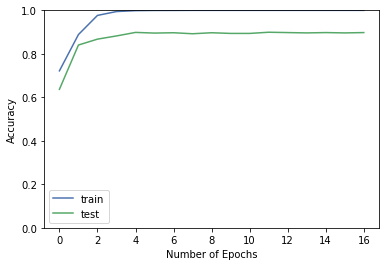

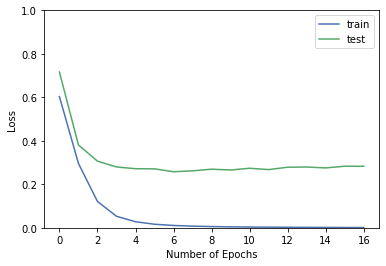

In [19]:
# get model's training history
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.ylabel('Accuracy')
plt.xlabel('Number of Epochs')
plt.ylim([0, 1])
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.ylabel('Loss')
plt.xlabel('Number of Epochs')
plt.ylim([0, 1])
plt.legend()
plt.show()

# Checking A Model Prediction

In [337]:
# We'll initiate our explainer here, as we can parlay its functionality with the prediction process easier
explainer = LimeTextExplainer(class_names=categories)

indx = 1
input_sentence = fetch_20newsgroups(subset='test', categories=categories).data[indx][:]
# tokenize
sequences = tokenizer.texts_to_sequences(input_sentence)
# make padding
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
exp = explainer.explain_instance(input_sentence, c_fn, num_features=15, num_samples=len(data), labels=[0,1,2,3])
# get prediction
weightings = [sum([x[1] for x in exp.as_list(label=y)]) for y in range(0,len(categories))]
predictions = weightings.index(max(weightings))
groundtruth = fetch_20newsgroups(subset='test', categories=categories).target[indx]

print( "\n\n\nPredicted values: " + categories[predictions] + " True Prediction = " + categories[groundtruth]+"\n\n\n")
print(input_sentence)




Predicted values: comp.graphics True Prediction = talk.religion.misc



From: ddennis@nyx.cs.du.edu (Dave Dennis)
Subject: Re: Adobe Type Manager - what good is it??
Organization: University of Denver, Dept. of Math & Comp. Sci.
Lines: 29

menchett@dws015.unr.edu (Peter J Menchetti) writes:

>The subject says it all. I bought Adobe Type Manager and find it completely
>useless. I ftped some atm fonts and couldn't install them. What's the use?
>Are you supposed to be able to convert ATM fonts to Truetype?

>If there's anyone out there who has this program and actually finds it 
>useful, enlighten me!

>Pete

There are some tricks to installing ATM to windows... install them first
to dos, then run the ATM control panel to get them into windows.

The best reason for ATM is that Adobe IS the standard.  Truetype is a
failed MS venture to undercut Adobe when Adobe was being nasty about
keeping their formats proprietary.  Just about any service bureau or print
shop will smirk and send you o

# AI Explainability Assessment With LIME

In [332]:
def c_fn(text):
    s = tokenizer.texts_to_sequences(text)
    d = pad_sequences(s, maxlen=MAX_SEQUENCE_LENGTH)
    return np.flip(model.predict(d),axis=1)

def draw_ev_chart(evidence, col, title_text):
    plt.figure(1, figsize=(10, len(evidence)/3.5))
    plt.barh(np.array(range(0,len(evidence)))+0.5,[t[1] for t in evidence], align='center',height=0.5, color=col)    # notice the 'height' argument
    plt.yticks(np.array(range(0,len(evidence)))+0.5, [t[0] for t in evidence], weight="normal", size="10")
    plt.xticks(weight='bold', size='8')
    plt.gca().axvline(0,color='k',lw=3)
    plt.title(title_text, weight="normal", size="10")
    plt.grid(False)
    plt.show()
    
def print_colorised(input_text, arg_categories, weightings, exp):
    print("\n\n\n\u001b[4m\u001b[1mColor Codes:\033[0m\n")
    for c in range(0, len(arg_categories)):
        print("\u001b[%sm       \033[0m %s" % ((41+c),arg_categories[c]))
    print("\n\n\n")
    
    class_colors = ['#d70000', '#008700', '#d7af00', '#005fff']
    plt.figure(1, figsize=(4, len(weightings)/2))
    plt.barh(np.array(range(0,len(weightings)))+0.5, weightings, align='center',height=0.5, color=class_colors)    # notice the 'height' argument
    plt.yticks(np.array(range(0,len(weightings)))+0.5, categories, weight="normal", size="10")
    plt.xticks(weight='bold', size='8')
    plt.gca().axvline(0,color='k',lw=3)   # poor man's zero level
    plt.title("Class Weightings", weight="normal", size="10")
    plt.grid(False)
    plt.show()
    
    print("\n\n\n")
    
    ww = weightings.copy()
    index_orders = []
    while(len(ww) > 2):
        index_to_drop = ww.index(max(ww))
        index_orders.append(index_to_drop)
        del ww[index_to_drop]
    index_orders.extend([1,0])
    
    word_class_list = []
    for l in range(0, len(arg_categories)):
        word_class_list.append([w[0] for w in exp.as_list(label=l)])
    reset_color_black = '\033[0m'
    constructed_replace_list = []
    for cl_v in range(0, len(word_class_list)):
        cl = index_orders[cl_v]
        for w in range(0, len(word_class_list[cl])):
            constructed_replace_list.append([len(word_class_list[cl][w]), word_class_list[cl][w], "\u001b[%sm" % (41+cl)])
    constructed_replace_list.sort(key=lambda x: x[0])
    output_text = input_text
    pattern_around = "(?<![a-zA-Z])"
    pattern_after = "(?![a-zA-Z])"
    for w in constructed_replace_list:
        output_text = re.compile(pattern_around+w[1]+pattern_after).sub( w[2]+w[1]+reset_color_black, output_text)
    print(output_text)
    

In [333]:
def run_explainability_test(input_sentence):
    # tokenize
    sequences = tokenizer.texts_to_sequences(input_sentence)
    # make padding
    data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    exp = explainer.explain_instance(input_sentence, c_fn, num_features=15, num_samples=len(data), labels=[0,1,2,3])
    # get prediction
    weightings = [sum([x[1] for x in exp.as_list(label=y)]) for y in range(0,len(categories))]
    print( "\n\n\nPredicted values: " + categories[weightings.index(max(weightings))])
    print_colorised(input_sentence, categories, weightings, exp)

    for class_n in range(0, len(categories)):
        draw_ev_chart(exp.as_list(label=class_n),class_colors[class_n],"Evidence Of %s" % (categories[class_n]))



### Let's test out two paragraphs that are highly distinct from one another - one about graphics, and the other about space:




Predicted values: comp.graphics



Color Codes:

        talk.religion.misc
        soc.religion.christian
        sci.space
        comp.graphics






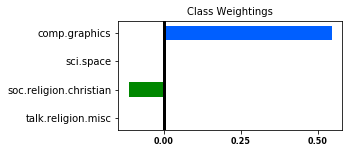





Computer graphics studies the manipulation of visual and geometric information using computational techniques. It focuses on the mathematical and computational foundations of image generation and processing rather than purely aesthetic issues. Computer graphics is often differentiated from the field of visualization, although the two fields have many similarities.


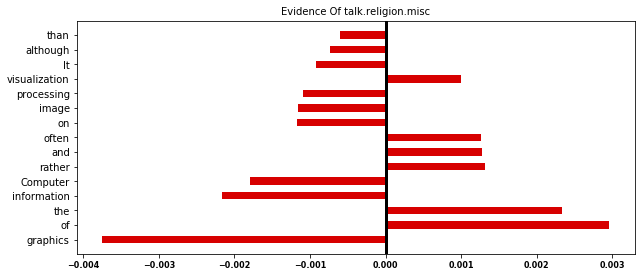

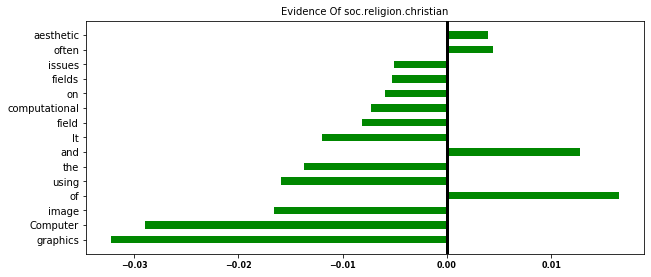

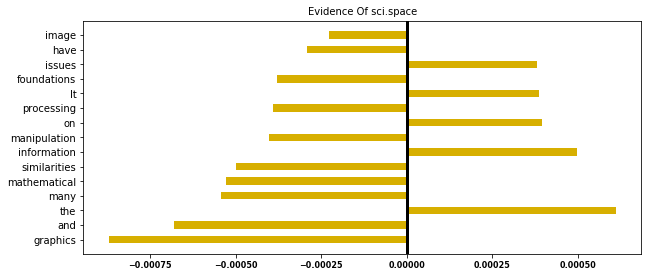

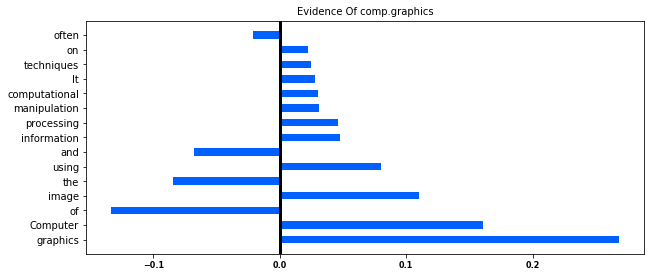

In [338]:
# A sentence about graphics
input_sentence = '''Computer graphics studies the manipulation of visual and geometric information using computational techniques. It focuses on the mathematical and computational foundations of image generation and processing rather than purely aesthetic issues. Computer graphics is often differentiated from the field of visualization, although the two fields have many similarities.'''
run_explainability_test(input_sentence)




Predicted values: sci.space



Color Codes:

        talk.religion.misc
        soc.religion.christian
        sci.space
        comp.graphics






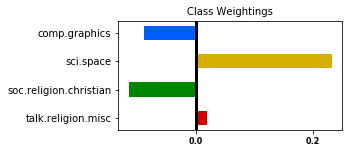





The Milky Way[a] is the galaxy that contains the Solar System, with the name describing the galaxy's appearance from Earth: a hazy band of light seen in the night sky formed from stars that cannot be individually distinguished by the naked eye. The term Milky Way is a translation of the Latin via lactea, from the Greek γαλαξίας κύκλος (galaxías kýklos, "milky circle").[17][18][19] From Earth, the Milky Way appears as a band because its disk-shaped structure is viewed from within. Galileo Galilei first resolved the band of light into individual stars with his telescope in 1610. Until the early 1920s, most astronomers thought that the Milky Way contained all the stars in the Universe.[20] Following the 1920 Great Debate between the astronomers Harlow Shapley and Heber Curtis,[21] observations by Edwin Hubble showed that the Milky Way is just one of many galaxies.


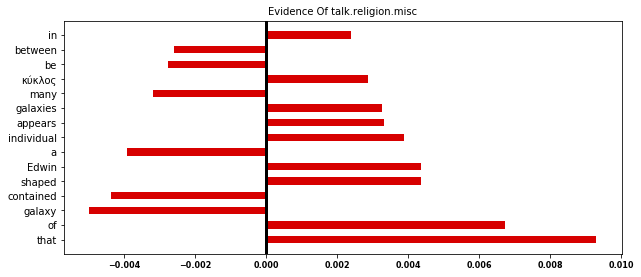

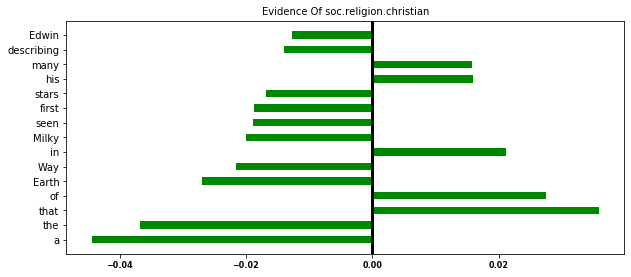

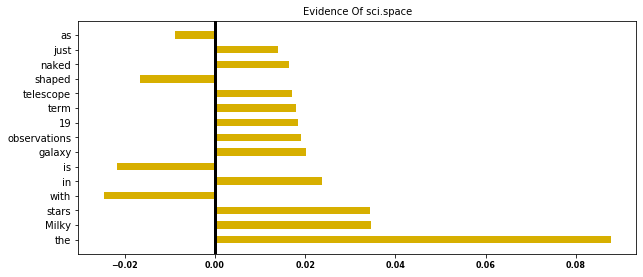

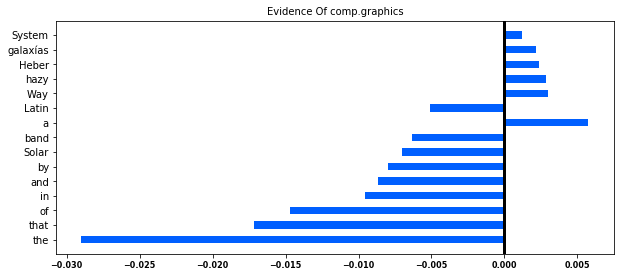

In [336]:
# A sentence about space
input_sentence = '''The Milky Way[a] is the galaxy that contains the Solar System, with the name describing the galaxy's appearance from Earth: a hazy band of light seen in the night sky formed from stars that cannot be individually distinguished by the naked eye. The term Milky Way is a translation of the Latin via lactea, from the Greek γαλαξίας κύκλος (galaxías kýklos, "milky circle").[17][18][19] From Earth, the Milky Way appears as a band because its disk-shaped structure is viewed from within. Galileo Galilei first resolved the band of light into individual stars with his telescope in 1610. Until the early 1920s, most astronomers thought that the Milky Way contained all the stars in the Universe.[20] Following the 1920 Great Debate between the astronomers Harlow Shapley and Heber Curtis,[21] observations by Edwin Hubble showed that the Milky Way is just one of many galaxies.'''
run_explainability_test(input_sentence)

### While the first test seemed quite promising, let's test a problem of greater classification difficulty -  distinction between a sentence about Christianity, and a sentence about Religion:




Predicted values: soc.religion.christian



Color Codes:

        talk.religion.misc
        soc.religion.christian
        sci.space
        comp.graphics






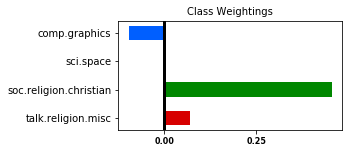





Christianity is an Abrahamic monotheistic religion based on the life and teachings of Jesus of Nazareth. Its adherents, known as Christians, believe that Jesus is the Christ, whose coming as the messiah was prophesied in the Hebrew Bible, called the Old Testament in Christianity, and chronicled in the New Testament.[1] It is the world's largest religion with about 2.4 billion followers.


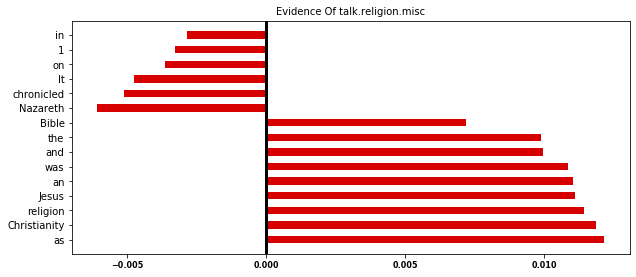

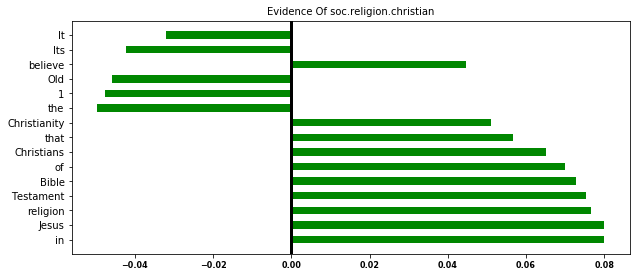

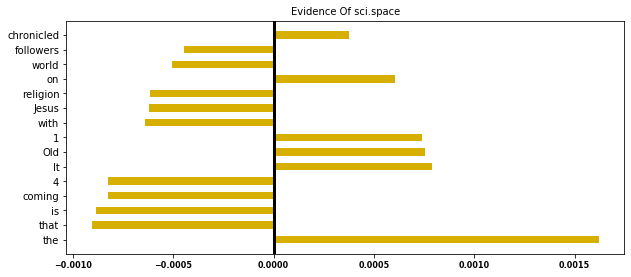

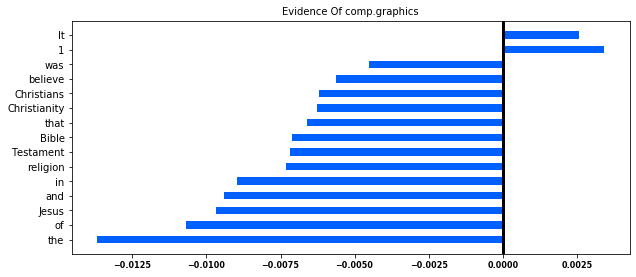

In [334]:
# A sentence about Christianity
input_sentence = "Christianity is an Abrahamic monotheistic religion based on the life and teachings of Jesus of Nazareth. Its adherents, known as Christians, believe that Jesus is the Christ, whose coming as the messiah was prophesied in the Hebrew Bible, called the Old Testament in Christianity, and chronicled in the New Testament.[1] It is the world's largest religion with about 2.4 billion followers."
run_explainability_test(input_sentence)




Predicted values: soc.religion.christian



Color Codes:

        talk.religion.misc
        soc.religion.christian
        sci.space
        comp.graphics






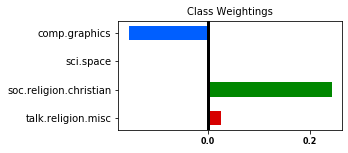





Some scholars classify religions as either universal religions that seek worldwide acceptance and actively look for new converts, or ethnic religions that are identified with a particular ethnic group and do not seek converts.[103] Others reject the distinction, pointing out that all religious practices, whatever their philosophical origin, are ethnic because they come from a particular culture.[104][105][106] Christianity, Islam, Buddhism and Jainism are universal religions while Hinduism and Judaism are ethnic religions.


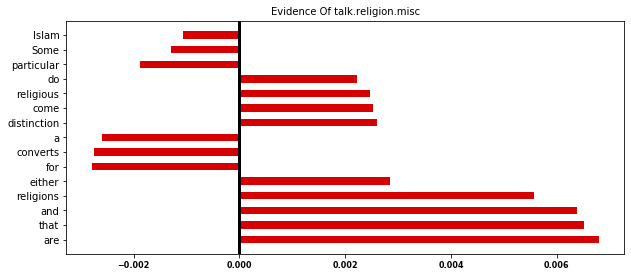

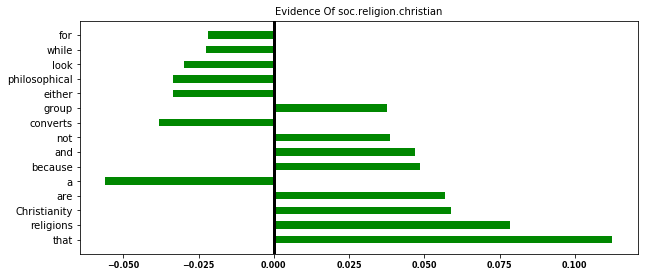

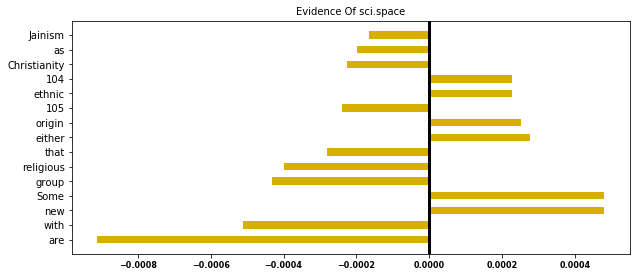

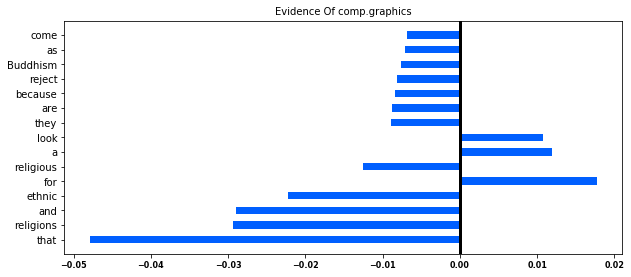

In [335]:
# A sentence about religion
input_sentence = "Some scholars classify religions as either universal religions that seek worldwide acceptance and actively look for new converts, or ethnic religions that are identified with a particular ethnic group and do not seek converts.[103] Others reject the distinction, pointing out that all religious practices, whatever their philosophical origin, are ethnic because they come from a particular culture.[104][105][106] Christianity, Islam, Buddhism and Jainism are universal religions while Hinduism and Judaism are ethnic religions."
run_explainability_test(input_sentence)

# Discussion

* What do the results of the explanabilities tell us about the classifier?
* How might we improve our model from these insights?
* Was there a way of hinting this problem from the accuracy and loss function?
* Is there a particular action that can be taken with regard to the dataset being used?
* What other methods exist for pulling out these explanability statistics?